In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import scipy as sc
import sympy as sp

In [39]:
#we need to read the file
#../input_data/trajNaCl.pdb
#500 timeframes

#bash command to filter
#grep ATOM trajNaCl.pdb | tr -s ' ' | cut -d' ' -f6-8 > filter_trajNaCl.txt

In [40]:
pairing = {
    0: "Na-Na",
    1: "Cl-Cl",
    2: "Na-Cl"
        }

coldic = {
    0: "red",
    1: "blue",
    2: "green",
}

kb = 8.3144621*1e-3 # K /K, A**2 kg s**-2
T = 298

In [41]:
def data_init(n):
    data = np.loadtxt("../input_data/filter_trajNaCl.txt") #500 blocks of 40 lines
    cell = 31.47
    bins = n #total number of bins, also affects the amount of values g gets
    ngr = 0 # what is ngr for ?
    delg = cell/(2*bins) #delg is bin size
    g = np.zeros(bins) 
    #First chunk over
    chunk = 40
    npart = chunk*501 #amount of particles, 20040, would be better as nlines but whatever now
    return data, cell, bins, ngr, delg, g, npart, chunk

In [42]:
#Based on Frenkel
def rdf(g, ngr, cell, data, delg, npart, chunk, pair):

    if pair == 0: #Na-Na

        for k in range(0, npart, chunk): #k for the different chunks/timeframes
            ngr = ngr + 1   #not very improtant, only used for normalization
            for i in range(k+0, k+chunk-1-20): #Start at line k, the beginning of a chunk, iterate till the 19th particle (Indexed as 0 till 18)
                for j in range(i+1, k+chunk-20 ): #Start at i+1 particle, iterate till the last, 20th particle (indexed i+1 till 19)
                    #distance between a particle pair
                    r = data[i]-data[j]
                    #implement periodic boundary conditions
                    r = r - cell*np.round(r/cell) # ok
                    r = np.linalg.norm(r) # ok
                    #half-box check & contribution
                    if r <= cell/2: #what is the reasoning here? - makes sense now, maximum radius, otherwise outside of the box, invalid data
                        l = int(r/(delg))
                        g[l] = g[l] + 2

    elif pair == 1: #Cl-Cl

        for k in range(0, npart, chunk): 
            ngr = ngr + 1  
            for i in range(k+20, k+chunk-1): #Iterate over all Cl particles, except the last one
                for j in range(i+1, k+chunk): #Start at the i+1 Cl particle, go the last particle
                    r = data[i]-data[j]
                    r = r - cell*np.round(r/cell) 
                    r = np.linalg.norm(r) 
                    if r <= cell/2: 
                        l = int(r/(delg))
                        g[l] = g[l] + 2

    elif pair == 2: #Na-Cl

        for k in range(0, npart, chunk): 
            ngr = ngr + 1 
            for i in range(k+0, k+20): # From the 1st Na particle, till the 20 the (0 till 19 places), k is a line, + 40 for the particles, -20 to remain in Na boundary,
                for j in range(k+20, k+chunk): #Iterate over the Cl particles
                    r = data[i]-data[j]
                    r = r - cell*np.round(r/cell) 
                    r = np.linalg.norm(r) 
                    if r <= cell/2:
                        l = int(r/(delg))
                        g[l] = g[l] + 2

    return g, ngr

In [43]:
def grdf(g, delg, ngr, bins, cell, pair):

    apart = 20 #actual amount of particles, not to be confused with nparts
    rho = apart/(cell**3)
    if pair == 2:
        rho = 2*rho
    #for pairing 0,1 we have 20 particles interacting, for 2, we have 40, so just double it
    
    r = []
    for i in range(0, bins): #i in [0, bins), inc +1
        r.append(delg*(i+0.5))  #So this will be the x-axis
        vol = ((i+1)**3  - i**3 )*delg**3 #what?
        nid = (4/3)*np.pi*vol*rho
        #vol and nid, seem a bit weird to me
        g[i] = g[i]/(ngr*apart*nid)  
        #The amount of information in the g[i] functions is derived by nparts, we normalized with the *actual* amount of particles in the box tho, not with timeframes*particles, 
        #kinda weird if you ask me
    return g, r

In [44]:
def main_fuc(pair, n=300):
    data, cell, bins, ngr, delg, g, npart, chunk = data_init(n)
    g, ngr = rdf(g, ngr, cell, data, delg, npart, chunk, pair)
    g, r = grdf(g, delg, ngr, bins, cell, pair)
    return g, np.array(r)

In [45]:
def plt_grdf(g, r, pair):
    plt.plot(r, g)
    plt.title(pairing[pair])
    plt.xlabel('r')
    plt.hlines(1, 0, 2*np.max(r), colors="red")
    plt.ylabel('g(r)')
    plt.xlim( (0, np.max(r)*1.1) )
    plt.ylim( (0, np.max(g)*1.1) )

fig, ax = plt.subplots(1, 4 , figsize=(22.00, 7.64))
for i in range(0, 3):
    g, r = main_fuc(i, 1000)
    ax[i].plot(r, g)
    ax[i].set_title(pairing[i])
    ax[i].set_xlabel('r')
    ax[i].set_ylabel("g(r)")
    ax[i].axhline(1, 0, 2*np.max(r), c="red") #colors="red"
    ax[i].set_xlim( (0, 16) )
    ax[i].set_ylim( (0, 4) )
    ax[3].plot(r, g, label=pairing[i], color=coldic[i])

ax[3].legend(loc="upper right")
ax[3].axhline(1, 0, 2*np.max(r), c="black")
ax[3].set_ylim( (0, 4) )
fig.show()

g_all = np.array([g0, g1, g2])
for i in range(0, 3):
    #info = "Some header info, seems to interfere with the website"
    np.savetxt("output_g_" + pairing[i] +".txt", list(zip(r0, g_all[i])), fmt="%16.14f") #header=info

<ipython-input-46-4d37e523c025>:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  g_s_all = np.array(g_s_all)


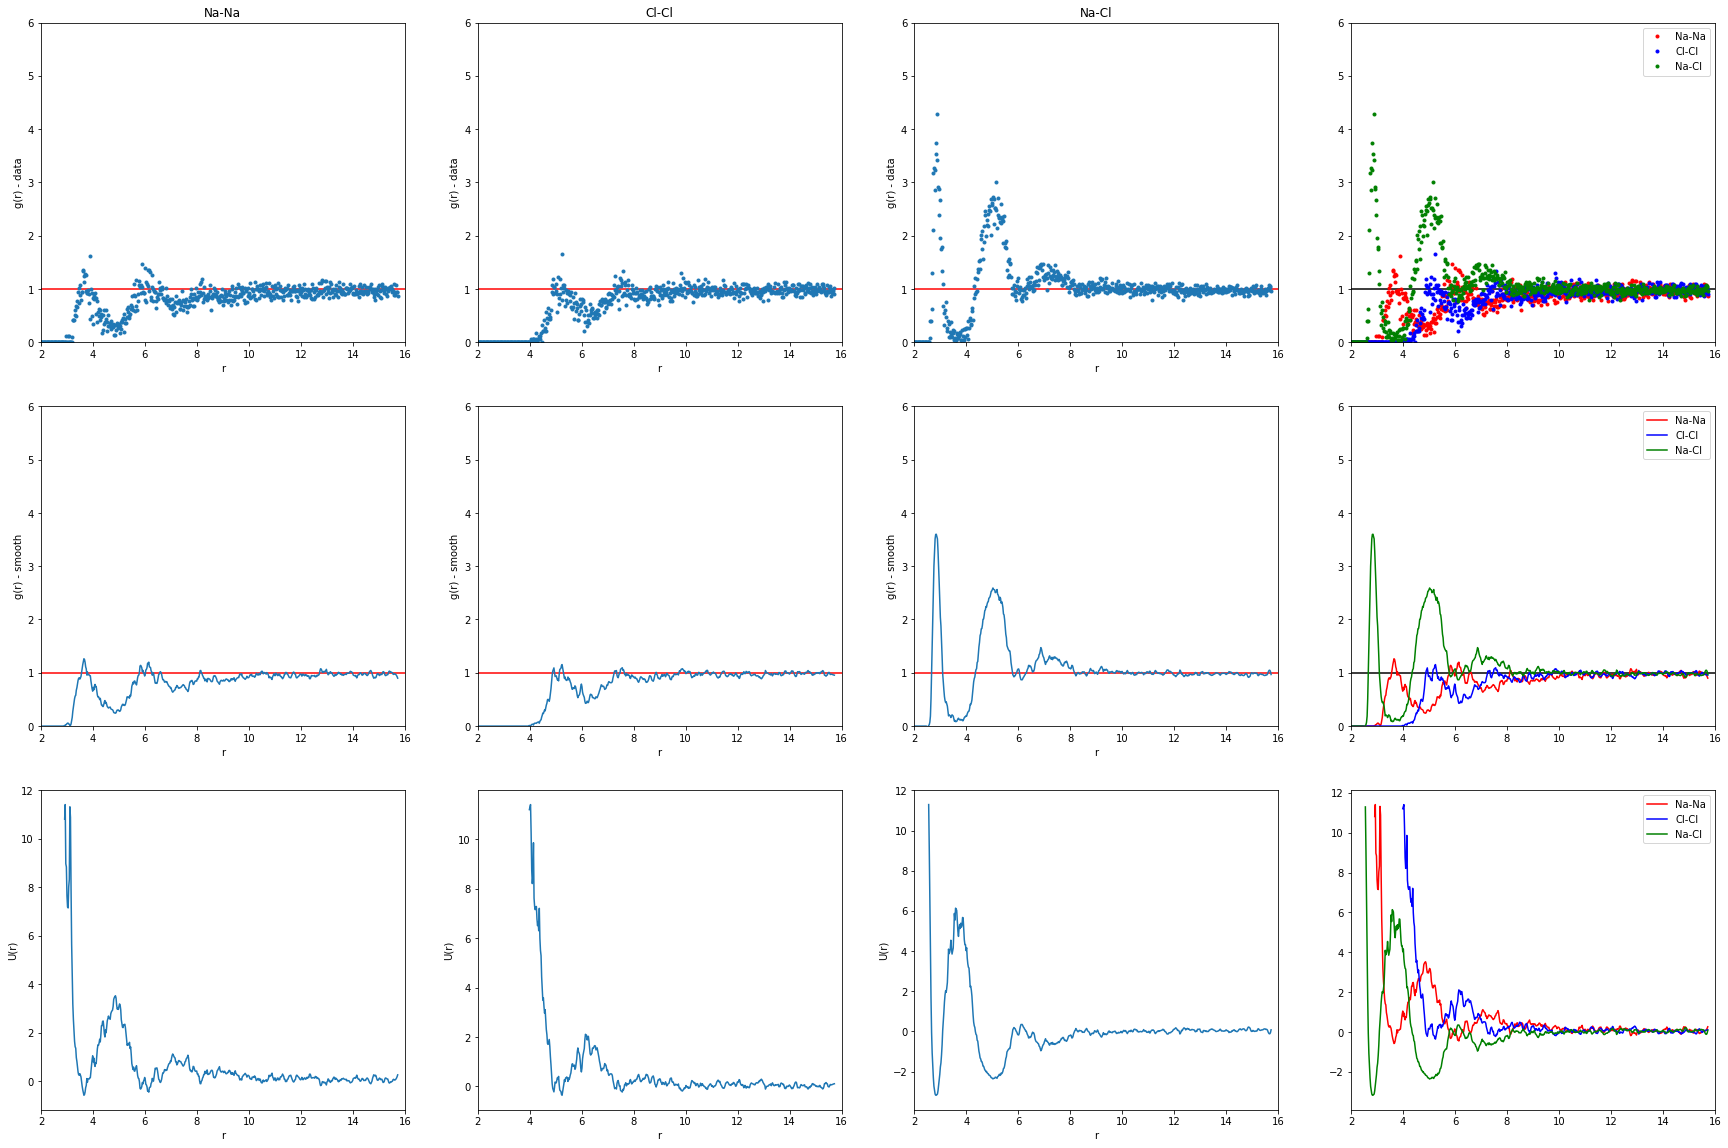

In [46]:
g_all = []
g_s_all = []


fig, ax = plt.subplots(3, 4 , figsize=(30.00, 20.00))
for i in range(0, 3):
    
    g, r = main_fuc(i, 700) #generate our proper g,r. r should have a length of 700 here
    g_all.append(g)
    ax[0, i].plot(r, g, marker=".", linestyle="None")
    ax[0, i].set_title(pairing[i])
    ax[0, i].set_xlabel('r')
    ax[0, i].set_ylabel("g(r) - data")
    ax[0, i].axhline(1, 0, 2*np.max(r), c="red", zorder=-1) #colors="red"
    ax[0, i].set_xlim( (2, 16) )
    ax[0, i].set_ylim( (0, 6) )
    ax[0, 3].plot(r, g, label=pairing[i], color=coldic[i], marker=".", linestyle="None")

    g_smooth = savgol_filter(g, 11, 3)
    ax[1, i].plot(r, g_smooth)
    #ax[1, i].set_title(pairing[i])
    ax[1, i].set_xlabel('r')
    ax[1, i].set_ylabel("g(r) - smooth")
    ax[1, i].axhline(1, 0, 2*np.max(r), c="red", zorder=-1) #colors="red"
    ax[1, i].set_xlim( (2, 16) )
    ax[1, i].set_ylim( (0, 6) )
    ax[1, 3].plot(r, g_smooth, label=pairing[i], color=coldic[i])

    

    ind = np.where(g_smooth>0.01)[0] #At this point we grab some indices where g_s >0.01 because we get artifacts otherwise
    g_smooth = g_smooth[ind]
    r_v = r[ind] #r_v is small in length than r
    g_s_all.append(g_smooth)

    info = pairing[i]
    info+= "\n Npoints = " + str(np.size(r_v)) 
    info+= "\n min = " + str(np.min(r_v)) + ", max = " + str(np.max(r_v))
    np.savetxt("output_g_" + pairing[i] +".txt", list(zip(r, g_all[i])), fmt="%16.14f")# header=info)
    np.savetxt("output_g_s_" + pairing[i] +".txt", list(zip(r_v, g_s_all[i])), fmt="%10.7f", header=info)


    #we only use the shorter length for plotting, g_smooth has 700 points
    V = -kb*T*np.log(g_smooth) #shouldnt it be ln(g/g_ref) ?
    ax[2, i].plot(r_v, V)
    #ax[2, i].set_title("Potential " + pairing[i])
    ax[2, i].set_xlabel('r')
    ax[2, i].set_ylabel("U(r)")
    #ax[2, i].axhline(1, 0, 2*np.max(r), c="red", zorder=-1) #colors="red"
    ax[2, i].set_xlim( (2, 16) )
    #ax[2, i].set_ylim( (0, ) )

    ax[2, 3].plot(r_v, V, label=pairing[i], color=coldic[i])

    ax[i, 3].set_xlim( (2, 16) )

    

ax[0, 3].legend(loc="upper right")
ax[0, 3].axhline(1, 0, 2*np.max(r), c="black", zorder=-1)
ax[0, 3].set_ylim( (0, 6) )

ax[1, 3].legend(loc="upper right")
ax[1, 3].axhline(1, 0, 2*np.max(r), c="black", zorder=-1)
ax[1, 3].set_ylim( (0, 6) )

ax[2, 3].legend(loc="upper right")

g_all = np.array(g_all)
g_s_all = np.array(g_s_all)
    

#remember, the main r array is just r, with 700 points

plt.savefig("output_0_rdf_pot.pdf")

Testing section

Trying to find optimal arguments for smoothing

<ipython-input-47-4760f3863e90>:53: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


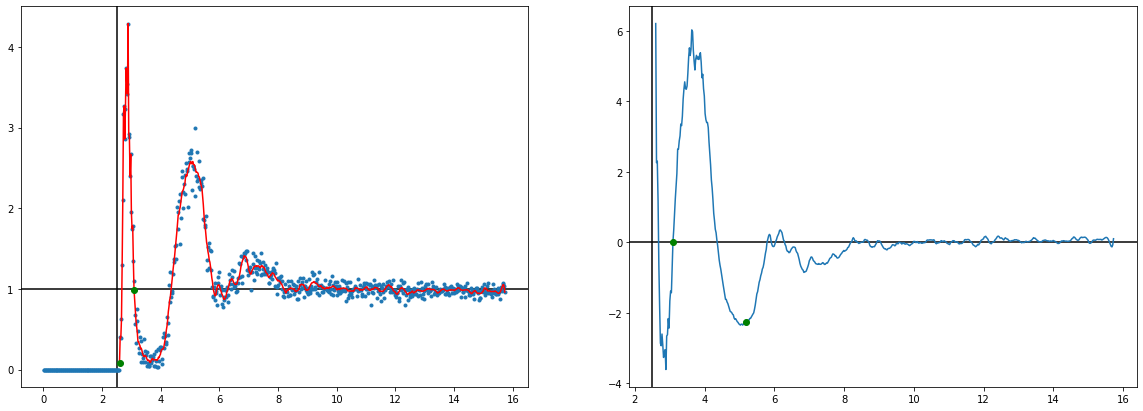

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7))

g_t, r_t = main_fuc(2, 700) #number of histograms



ind0 = np.where(g_t > 0.08)[0][0]
g_s = g_t[ind0:]
r_s = r_t[ind0:]
g_s0 = savgol_filter(g_s, 31 , 7, mode="interp")
g_s1 = savgol_filter(g_s, 3 , 2, mode="interp") #smoothing parameters 



"""
(11, 5) is smooth put loses the first peak
(9, 5) keeps the peak but is a bit jumpy

(65, 9) surprisingly good, misses only 1 point from the peak
"""

#plot data
ax[0].plot(r_t, g_t, marker=".", linestyle="None", zorder=0)
b = 22 #boundary
g_f = np.concatenate((g_s1[0:b], g_s0[b:])) #g fused
#plot smooth fct
ax[0].plot(r_s, g_f , c="red", zorder=1)


#plot a reference point
ax[0].plot(r_t[ind0], g_t[ind0], c="green", marker="o", zorder=2)
ax[0].plot(r_s[b], g_f[b], c="green", marker="o", zorder=2)

#ax[0].plot(r_s, g_sc, c="green")#, marker=".")
#plot convergence line
ax[0].axhline(1, 0, 2*np.max(r), c="black", zorder=-1) #colors="red"
ax[0].axvline(2.5, -1, 2, c="black", zorder=-1)



#potential
ind1 = np.where(g_f>0.01)[0]
g_v = g_f[ind1]
r_v = r_s[ind1]
#ind1 size is the same as g_f for this case
V = -kb*T*np.log(g_v)
ax[1].plot(r_v, V)#, marker=".", linestyle="None")
ax[1].axhline(0, 0, 2*np.max(r), c="black", zorder=-1) #colors="red"
ax[1].axvline(2.5, -1, 2, c="black", zorder=-1)
ax[1].plot(r_v[ind0], V[ind0], c="green", marker="o", zorder=2)
ax[1].plot(r_v[b], V[b], c="green", marker="o", zorder=2)

fig.show()
plt.savefig("testing.pdf")

Pay attention, loaded data is in nm not A

<ipython-input-48-c2df4b66925a>:45: RuntimeWarning: invalid value encountered in log
  V_int = -kb*T*np.log(g_int)
<ipython-input-48-c2df4b66925a>:45: RuntimeWarning: invalid value encountered in log
  V_int = -kb*T*np.log(g_int)


IndexError: index 522 is out of bounds for axis 0 with size 522

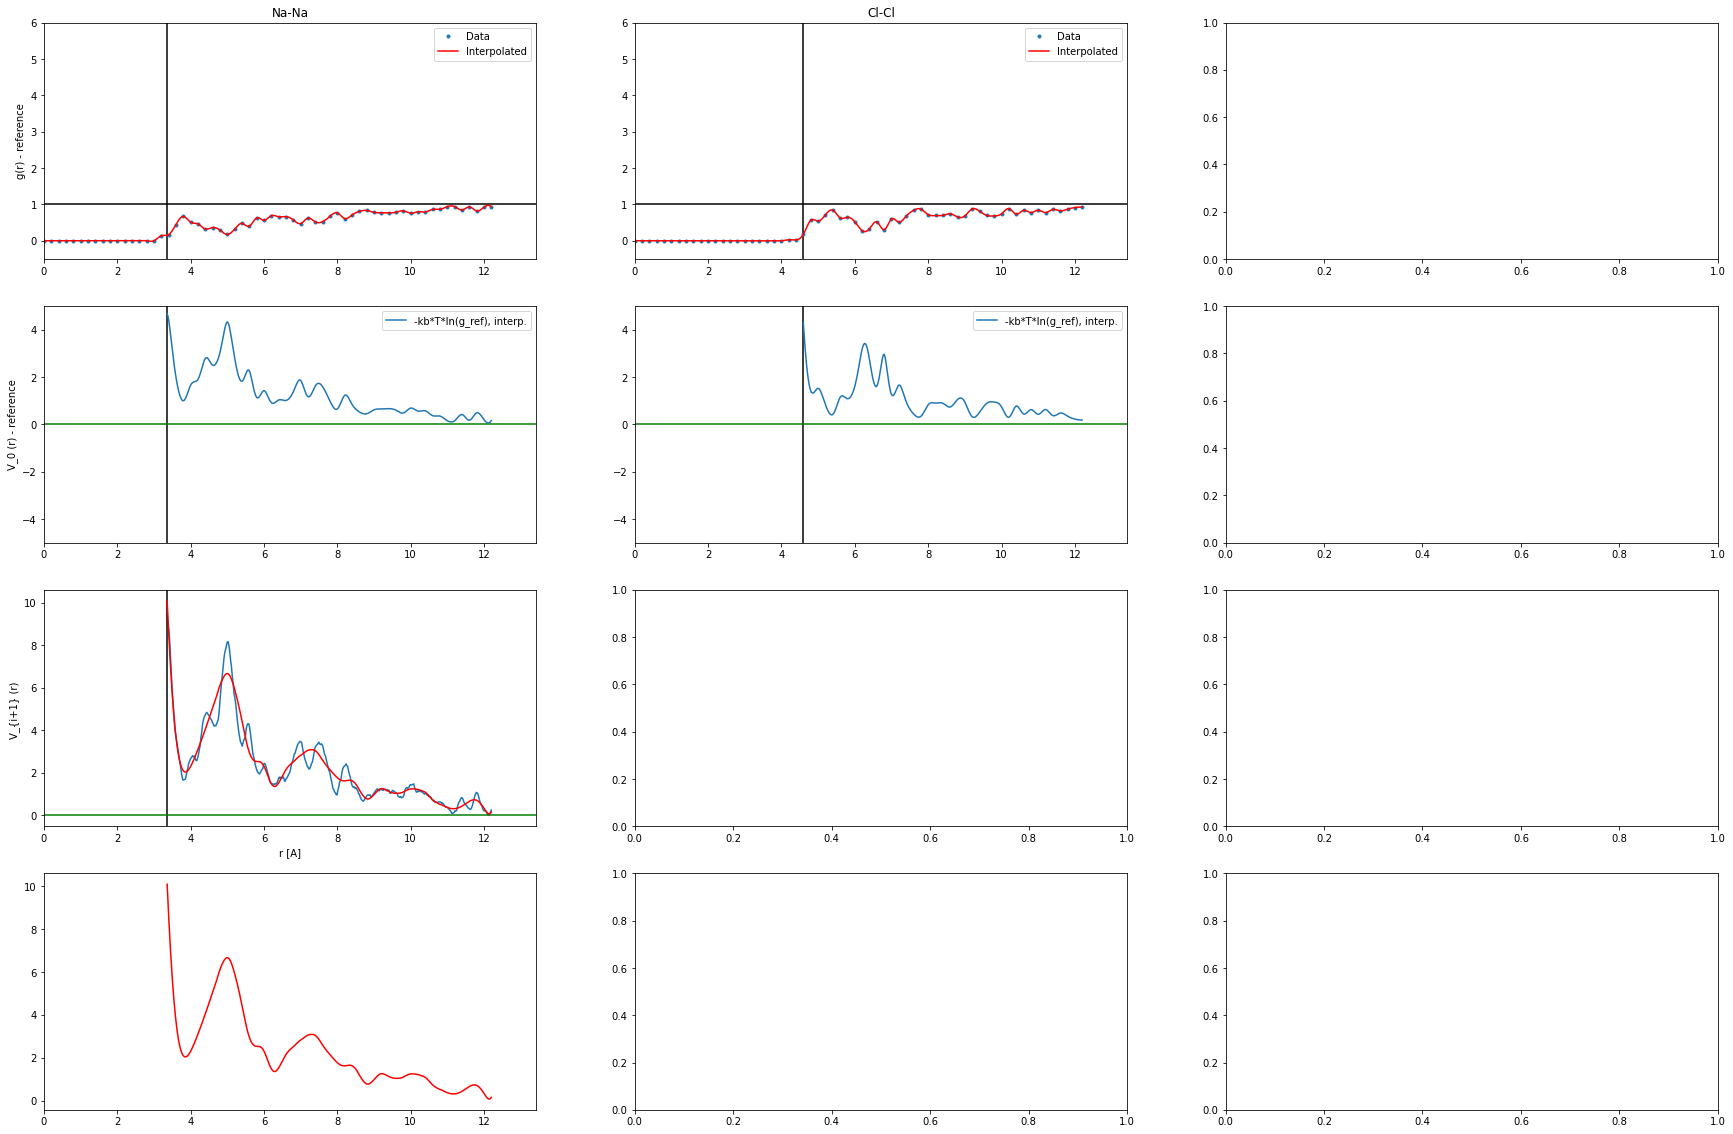

In [48]:
#Calculating the V_1 here and interpolating

from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d

#Warning! Re-generate a proper universal r value
#Right now im borrowing one from the previous cell

g_all = [] # rdf 
s_all = [] # smoothed
v_all = [] 
r_all = []

fig, ax = plt.subplots(4, 3, figsize=(30, 20))
for i in range(0, 3):
    rdf_pair = pairing[i]

    #We load the data, the atomistic rdf and the distance array, g_at and r_at
    #I need that for the initial division
    fn = "./rdf_given/target_rdf_"+ rdf_pair + ".xvg"
    r_at, g_at = np.loadtxt(fn, unpack=True, skiprows=25)
    r_at = 10*r_at #change nm to Angstrom

    #interpolate, but we can only interpolate up to the length of r_at i.e last element.
    #r goes to 16 r_at goes to 12 or so.
    f_g_int = interp1d(r_at, g_at, kind='cubic')
    r_int = r[r < r_at[-1]] #so we take values up to the limit, r_int is our shortened array, missing elements of r towards the end
    g_int = f_g_int(r_int) # f_g_int is the function, we create the data points as g_int
    #so r_int is a shorter r, all good

    ####g_ref plot
    ax[0, i].plot(r_at, g_at, marker=".", linestyle="None", label="Data")
    ax[0, i].plot(r_int, g_int, color="red", label="Interpolated")
    
    ax[0, i].set_title(pairing[i])
    ax[0, i].axhline(1, 0, 2*np.max(r_at), c="black", zorder=-1)
    ax[0, i].set_ylim( (-0.5, 6) )
    ax[0, i].set_xlim( (0, r_at[-1]*1.1) )
    ax[0, 0].set_ylabel("g(r) - reference")
    ax[0, i].legend(loc="upper right")
    #ax[0, i].set_xlabel("r [A]")

    ######V_0 of g_ref plot
    #ax[1, i].set_title(pairing[i])
    V_int = -kb*T*np.log(g_int)

    indi = np.where(g_int>0.15) #FILTER - too much?
    #indi is just a filter, used for the display data
    ax[1, i].plot(r_int[indi], V_int[indi], label="-kb*T*ln(g_ref), interp.")
    ax[1, i].legend(loc="upper right")

    
    x_0 = r_int[indi][0] #where we begin
    ax[1, i].axvline( x_0, 0, 1, c="black", zorder=-1, label=str(x_0))
    ax[0, i].axvline( x_0, 0, 1, c="black", zorder=-1)
    ax[1, i].axhline(0, 0, 2*np.max(r_at), c="green", zorder=-1)
    ax[1, i].set_ylim( (-5, 5) )
    ax[1, i].set_xlim( (0, r_at[-1]*1.1) )
    ax[1, 0].set_ylabel("V_0 (r) - reference")
    #ax[1, i].set_xlabel("r [A]")


    ### V_i = V_0 + kbT*ln()


    g_temp = g_s_all[i] #Based on i take NaNa, ClCl or NaCl
    g_temp = g_temp[0: np.size(r_int)] #we shorten the smoothened function from 700 points to the length of r_int, to match it

    #introduce some more filters here?
    #i used 0.01 for g_smooth before
    #dont use indi here, but a combination of indices for g_smooth and g_int 


    V_step = V_int[indi] + kb*T*np.log(g_temp[indi]/g_int[indi])

    V_step_s = savgol_filter(V_step, 121, 8)

    ax[2, i].plot(r_int[indi], V_step, label="V_(i+1) = V_i + ln(g_i/g_int_ref)", zorder=-1)
    ax[2, i].plot(r_int[indi], V_step_s, label="V_(i+1) = V_i + ln(g_i/g_int_ref) - smoothed", color="red", zorder=1)

    ax[2, i].axvline( x_0, 0, 1, c="black", zorder=-1, label=str(x_0)) #x_0 used is calculated before
    ax[2, i].axhline(0, 0, 2*np.max(r_at), c="green", zorder=-1)
    #ax[1, i].set_ylim( (-1, 2) )
    ax[2, i].set_xlim( (0, r_at[-1]*1.1) )
    ax[2, 0].set_ylabel(r"V_{i+1} (r) ")
    ax[2, i].set_xlabel("r [A]")

    ax[3, i].plot(r_int[indi], V_step_s, label="V_(i+1) = V_i + ln(g_i/g_int_ref) - smoothed", color="red", zorder=1)
    ax[3, i].set_xlim( (0, r_at[-1]*1.1) )

    v_all.append(V_step_s)
    r_all.append(r_int[indi])


In [ ]:
for i in range(0, 3):
    #info = "Some header info, seems to interfere with the website"
    zer = np.zeros(np.size(r_all[i]))
    np.savetxt("./output_v/v_1/output_v1_" + pairing[i] +".xvg", list(zip(r_all[i], v_all[i])), fmt="%12.6f") #header=info
    #np.savetxt("./output_v/v_1/output_v1_" + pairing[i] +".xvg", list(zip(r_all[i], zer, zer, v_all[i], zer, zer ,zer)), fmt="%12.6f") #header=info